In [1]:
import tensorflow as tf
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load and prepare data

In [1]:
from PIL import Image
import numpy as np
import cv2
from keras.preprocessing.image import img_to_array
import tensorflow as tf
import shutil
import os

dst_dir = ['dataset_sunrgbd/train_rgb/', 'dataset_sunrgbd/train_depth/', 'dataset_sunrgbd/train_label/', 'dataset_sunrgbd/test_rgb/', 'dataset_sunrgbd/test_depth/', 'dataset_sunrgbd/test_label/']

x1_train = []
for archivo in os.listdir('dataset_sunrgbd/train_rgb'):
    img = Image.open(os.path.join('dataset_sunrgbd/train_rgb',archivo))
#     img = cv2.resize(img_to_array(img), dsize=(96,128))
    x1_train.append(np.asarray(img_to_array(img)))
x1_train = np.array(x1_train)
print(x1_train.shape)

x1_test = []
for archivo in os.listdir('dataset_sunrgbd/test_rgb'):
    img = Image.open(os.path.join('dataset_sunrgbd/test_rgb',archivo))
    img = cv2.resize(img_to_array(img), dsize=(96,128))
    x1_test.append(np.asarray(img))
x1_test = np.array(x1_test)
print(x1_test.shape)

x2_train = []
for archivo in os.listdir('dataset_sunrgbd/train_depth'):
    img = Image.open(os.path.join('dataset_sunrgbd/train_depth',archivo))
    img = cv2.cvtColor(cv2.resize(img_to_array(img), dsize=(96,128)), cv2.COLOR_GRAY2RGB)
    x2_train.append(np.asarray(img))
x2_train = np.array(x2_train)
print(x2_train.shape)

x2_test = []
for archivo in os.listdir('dataset_sunrgbd/test_depth'):
    img = Image.open(os.path.join('dataset_sunrgbd/test_depth',archivo))
    img = cv2.cvtColor(cv2.resize(img_to_array(img), dsize=(96,128)), cv2.COLOR_GRAY2RGB)
    x2_test.append(np.asarray(img))
x2_test = np.array(x2_test)
print(x2_test.shape)

y_train = []
for archivo in os.listdir('dataset_sunrgbd/train_label'):
    img = np.load(os.path.join('dataset_sunrgbd/train_label',archivo))
    img = cv2.resize(img_to_array(img), dsize=(96,128))
    y_train.append(img)
y_train = np.array(y_train).astype('uint8')
y_train = tf.keras.utils.to_categorical(y_train, dtype='float32')
print(y_train.shape)

y_test = []
for archivo in os.listdir('dataset_sunrgbd/test_label'):
    img = np.load(os.path.join('dataset_sunrgbd/test_label',archivo))
    img = cv2.resize(img_to_array(img), dsize=(96,128))
    y_test.append(img)
y_test = np.array(y_test).astype('uint8')
y_test = tf.keras.utils.to_categorical(y_test, dtype='float32')
print(y_test.shape)

del img
# y = tf.keras.utils.to_categorical(label_data, dtype='uint8')
# y.shape

(587, 531, 681, 3)
(572, 128, 96, 3)


KeyboardInterrupt: 

In [3]:
from sklearn.model_selection import train_test_split

x = np.array(list(zip(x1_train, x2_train)))
del x1_train, x2_train

X_train, X_val, y_train, y_val = train_test_split(x,y_train,test_size=0.2)

x1_train, x2_train = X_train[:, 0], X_train[:, 1]
x1_val, x2_val = X_val[:, 0], X_val[:, 1]

del X_train, X_val

In [4]:
from segmentation_models import get_preprocessing

BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)


x1_train = preprocess_input(x1_train)
x2_train = preprocess_input(x2_train)
x1_val = preprocess_input(x1_val)
x2_val = preprocess_input(x2_val)
x1_test = preprocess_input(x1_test)
x2_test = preprocess_input(x2_test)

Segmentation Models: using `keras` framework.


In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rotation_range=15,
        rescale=1./255,
        shear_range=0.02,
        zoom_range=[0.9, 1.25],
        width_shift_range=0.1,
        height_shift_range=0.1,
        fill_mode="reflect" #'nearest')
val_datagen = ImageDataGenerator(
        rescale=1./255)

In [6]:
train_datagen.fit(x1_train)
val_datagen.fit(x1_val)

In [7]:
train = train_datagen.flow([x1_train, x2_train], y_train, batch_size=8)
validation = val_datagen.flow([x1_val, x2_val], y_val, batch_size=8)

# Create model

In [8]:
from segmentation_models import Unet
from segmentation_models.utils import set_trainable
import segmentation_models as sm


sm.set_framework('tf.keras')
sm.framework()

pretrained_model_1 = Unet(backbone_name='resnet34', encoder_weights='imagenet', encoder_freeze=True, classes=30, activation='softmax', input_shape=(None, None, 3))
pretrained_model_1.summary()
for layer in pretrained_model_1.layers:
    layer._name += '_1'

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [9]:
pretrained_model_2 = Unet(backbone_name='resnet34', encoder_weights='imagenet', encoder_freeze=True, classes=30, activation='softmax', input_shape=(None, None, 3))
pretrained_model_2.summary()
for layer in pretrained_model_2.layers:
    layer._name += '_2'

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_34 (ZeroPadding2 (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_34[0][0]          
____________________________________________________________________________________________

In [10]:
#last layers
rgb_last = pretrained_model_1.get_layer('add_15_1')
depth_last = pretrained_model_2.get_layer('add_31_2')
print('model_1 layer output shape: ', rgb_last.output_shape)
print('model_2 layer output shape: ', depth_last.output_shape)
output_1 = rgb_last.output
output_2 = depth_last.output

# Middle layers
rgb_stage_1 = pretrained_model_1.get_layer('stage1_unit1_relu1_1')
depth_stage_1 = pretrained_model_2.get_layer('stage1_unit1_relu1_2')
rgb_stage_2 = pretrained_model_1.get_layer('stage2_unit1_relu1_1')
depth_stage_2 = pretrained_model_2.get_layer('stage2_unit1_relu1_2')
rgb_stage_3 = pretrained_model_1.get_layer('stage3_unit1_relu1_1')
depth_stage_3 = pretrained_model_2.get_layer('stage3_unit1_relu1_2')
rgb_stage_4 = pretrained_model_1.get_layer('stage4_unit1_relu1_1')
depth_stage_4 = pretrained_model_2.get_layer('stage4_unit1_relu1_2')

rgb_fusion_1 = rgb_stage_1.output
depth_fusion_1 = depth_stage_1.output
rgb_fusion_2 = rgb_stage_2.output
depth_fusion_2 = depth_stage_2.output
rgb_fusion_3 = rgb_stage_3.output
depth_fusion_3 = depth_stage_3.output
rgb_fusion_4 = rgb_stage_4.output
depth_fusion_4 = depth_stage_4.output

model_1 layer output shape:  (None, None, None, 512)
model_2 layer output shape:  (None, None, None, 512)


In [11]:
def rgbd_fusion(input_r,input_d,reshape_size,label):
    r = tf.keras.layers.GlobalAveragePooling2D()(input_r)
    r = tf.keras.layers.Reshape((1,1,reshape_size))(r)
    r = tf.keras.layers.Conv2D(32,kernel_size=(1,1),strides=(1,1),activation='relu')(r)
    r = tf.keras.layers.Conv2D(reshape_size,kernel_size=(1,1),strides=(1,1),activation='sigmoid')(r)
    m_1 = tf.keras.layers.Multiply()([input_r,r])
    
    d = tf.keras.layers.GlobalAveragePooling2D()(input_d)
    d = tf.keras.layers.Reshape((1,1,reshape_size))(d)
    d = tf.keras.layers.Conv2D(32,kernel_size=(1,1),strides=(1,1),activation='relu')(d)
    d = tf.keras.layers.Conv2D(reshape_size,kernel_size=(1,1),strides=(1,1),activation='sigmoid')(d)
    m_2 = tf.keras.layers.Multiply()([input_d,d])
    name = 'fusion' + label
    last = tf.keras.layers.Add(name=name)([m_1,m_2])
    
    return last

def decode_layer(input_de,input_ad,filters):
    x = tf.keras.layers.UpSampling2D(size=(2,2), interpolation="nearest")(input_de)
    x = tf.keras.layers.Concatenate()([x,input_ad])
    x = tf.keras.layers.Conv2D(filters,kernel_size=(3,3),activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = tf.keras.layers.Conv2D(filters,kernel_size=(3,3),activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    return x


def last_decode_layer(input_de,filters):
    x = tf.keras.layers.UpSampling2D(size=(2,2), interpolation="nearest")(input_de)
    x = tf.keras.layers.Conv2D(filters,kernel_size=(3,3),activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = tf.keras.layers.Conv2D(filters,kernel_size=(3,3),activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    return x

In [12]:
fusion_1 = rgbd_fusion(rgb_fusion_1,depth_fusion_1,64,'_1')
print(fusion_1.shape)
fusion_2 = rgbd_fusion(rgb_fusion_2,depth_fusion_2,64,'_2')
print(fusion_2.shape)
fusion_3 = rgbd_fusion(rgb_fusion_3,depth_fusion_3,128,'_3')
print(fusion_3.shape)
fusion_4 = rgbd_fusion(rgb_fusion_4,depth_fusion_4,256,'_4')
print(fusion_4.shape)
fusion_last = rgbd_fusion(output_1, output_2,512,'_last')
print(fusion_last.shape)

(None, None, None, 64)
(None, None, None, 64)
(None, None, None, 128)
(None, None, None, 256)
(None, None, None, 512)


In [13]:
xr = decode_layer(fusion_last,fusion_4,1024)
xr = decode_layer(xr,fusion_3,512)
xr = decode_layer(xr,fusion_2,256)
xr = decode_layer(xr,tf.keras.layers.UpSampling2D(size=(2,2), interpolation="nearest")(fusion_1),128)
xr = last_decode_layer(xr,64)

xr = tf.keras.layers.Conv2D(38, kernel_size=(1, 1), activation='softmax', padding='same', name='last_layer')(xr)

model = tf.keras.Model(inputs=[pretrained_model_1.input, pretrained_model_2.input], outputs=xr, name='myModel')
# encoder_fusion = tf.keras.Model(inputs=[pretrained_model_1.input, pretrained_model_2.input], outputs=fusion)
model.summary()

Model: "myModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data_1 (InputLayer)             [(None, None, None,  0                                            
__________________________________________________________________________________________________
data_2 (InputLayer)             [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data_1 (BatchNormalization)  (None, None, None, 3 9           data_1[0][0]                     
__________________________________________________________________________________________________
bn_data_2 (BatchNormalization)  (None, None, None, 3 9           data_2[0][0]                     
____________________________________________________________________________________________

In [14]:
stage_fusion = model.get_layer('last_layer')
print(' layer output shape: ', stage_fusion.output_shape)

 layer output shape:  (None, None, None, 38)


# Training the model

## Plot Training accuracy and loss

In [ ]:
import matplotlib.pyplot as plt

def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['accuracy'], color="green")
    plt.plot(history1.history['val_accuracy'], 'r--', color="green")
    plt.plot(history2.history['accuracy'], color="blue")
    plt.plot(history2.history['val_accuracy'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()

## metrics

In [16]:
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
#seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

## callbacks

In [17]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_best_weights.hdf5".format('seg_model_2')

checkpoint = ModelCheckpoint(weight_path, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', min_delta=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_iou_score", 
                      mode="max", 
                      patience=25) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

## Model fit

In [18]:
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import precision, iou_score

model.compile(optimizer="Adam", loss=bce_logdice_loss, 
              metrics=[dice_coef, 
                       'accuracy', 
                       true_positive_rate, 
                       iou_score
                      ])

history = model.fit(train, epochs=1000, verbose=1, validation_data=validation, callbacks=callbacks_list)

Epoch 1/1000
59/59 [==============================] - 47s 564ms/step - loss: 2.2385 - dice_coef: 0.2754 - accuracy: 0.2939 - true_positive_rate: 0.2153 - iou_score: 0.0199 - val_loss: 5.3660 - val_dice_coef: 0.1982 - val_accuracy: 0.2043 - val_true_positive_rate: 0.1921 - val_iou_score: 0.0087

Epoch 00001: val_iou_score improved from -inf to 0.00868, saving model to seg_model_2_best_weights.hdf5
Epoch 2/1000
59/59 [==============================] - 27s 452ms/step - loss: 1.3537 - dice_coef: 0.3817 - accuracy: 0.3792 - true_positive_rate: 0.3638 - iou_score: 0.0259 - val_loss: 1.4268 - val_dice_coef: 0.3528 - val_accuracy: 0.3648 - val_true_positive_rate: 0.3205 - val_iou_score: 0.0240

Epoch 00002: val_iou_score improved from 0.00868 to 0.02399, saving model to seg_model_2_best_weights.hdf5
Epoch 3/1000
59/59 [==============================] - 27s 452ms/step - loss: 1.1074 - dice_coef: 0.4204 - accuracy: 0.4198 - true_positive_rate: 0.4142 - iou_score: 0.0300 - val_loss: 1.2550 - val_


Epoch 00043: val_iou_score did not improve from 0.05870
Epoch 44/1000
59/59 [==============================] - 27s 455ms/step - loss: 0.3703 - dice_coef: 0.7351 - accuracy: 0.7346 - true_positive_rate: 0.7334 - iou_score: 0.0835 - val_loss: 0.6574 - val_dice_coef: 0.5680 - val_accuracy: 0.5693 - val_true_positive_rate: 0.5663 - val_iou_score: 0.0571

Epoch 00044: val_iou_score did not improve from 0.05870
Epoch 45/1000
59/59 [==============================] - 27s 455ms/step - loss: 0.3685 - dice_coef: 0.7365 - accuracy: 0.7360 - true_positive_rate: 0.7347 - iou_score: 0.0841 - val_loss: 0.6568 - val_dice_coef: 0.5671 - val_accuracy: 0.5686 - val_true_positive_rate: 0.5653 - val_iou_score: 0.0566

Epoch 00045: val_iou_score did not improve from 0.05870
Epoch 46/1000
59/59 [==============================] - 27s 455ms/step - loss: 0.3692 - dice_coef: 0.7361 - accuracy: 0.7353 - true_positive_rate: 0.7343 - iou_score: 0.0842 - val_loss: 0.6615 - val_dice_coef: 0.5674 - val_accuracy: 0.568

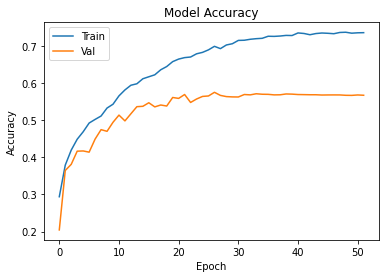

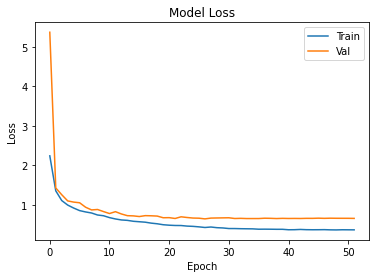

In [19]:
plot_acc(history)
plot_loss(history)

In [20]:
# # Para pasar la segmentacion a imagen
# np.argmax(a, axis=1)

# Fine tunning

In [24]:
# release all layers for training
# set all layers trainable and recompile model
for layer in model.layers:
    layer.trainable=True 

In [26]:
# continue training
history = model.fit(train, epochs=100, verbose=1, validation_data=validation, callbacks=callbacks_list)

Epoch 1/100
59/59 [==============================] - 27s 454ms/step - loss: 0.3686 - dice_coef: 0.7358 - accuracy: 0.7361 - true_positive_rate: 0.7340 - iou_score: 0.0844 - val_loss: 0.6602 - val_dice_coef: 0.5666 - val_accuracy: 0.5679 - val_true_positive_rate: 0.5648 - val_iou_score: 0.0568

Epoch 00001: val_iou_score did not improve from 0.05870
Epoch 2/100
59/59 [==============================] - 27s 454ms/step - loss: 0.3622 - dice_coef: 0.7403 - accuracy: 0.7400 - true_positive_rate: 0.7384 - iou_score: 0.0848 - val_loss: 0.6611 - val_dice_coef: 0.5688 - val_accuracy: 0.5677 - val_true_positive_rate: 0.5669 - val_iou_score: 0.0579

Epoch 00002: val_iou_score did not improve from 0.05870
Epoch 3/100
59/59 [==============================] - 27s 453ms/step - loss: 0.3640 - dice_coef: 0.7394 - accuracy: 0.7387 - true_positive_rate: 0.7374 - iou_score: 0.0846 - val_loss: 0.6604 - val_dice_coef: 0.5672 - val_accuracy: 0.5675 - val_true_positive_rate: 0.5653 - val_iou_score: 0.0576

Epo

59/59 [==============================] - 27s 452ms/step - loss: 0.3646 - dice_coef: 0.7389 - accuracy: 0.7387 - true_positive_rate: 0.7368 - iou_score: 0.0840 - val_loss: 0.6601 - val_dice_coef: 0.5672 - val_accuracy: 0.5677 - val_true_positive_rate: 0.5652 - val_iou_score: 0.0572

Epoch 00024: val_iou_score did not improve from 0.05870
Epoch 25/100
59/59 [==============================] - 27s 452ms/step - loss: 0.3641 - dice_coef: 0.7386 - accuracy: 0.7388 - true_positive_rate: 0.7366 - iou_score: 0.0847 - val_loss: 0.6568 - val_dice_coef: 0.5688 - val_accuracy: 0.5684 - val_true_positive_rate: 0.5668 - val_iou_score: 0.0586

Epoch 00025: val_iou_score did not improve from 0.05870
Epoch 26/100
59/59 [==============================] - 27s 453ms/step - loss: 0.3601 - dice_coef: 0.7419 - accuracy: 0.7415 - true_positive_rate: 0.7400 - iou_score: 0.0850 - val_loss: 0.6547 - val_dice_coef: 0.5680 - val_accuracy: 0.5686 - val_true_positive_rate: 0.5660 - val_iou_score: 0.0584

Epoch 00026: 